## Packages
os: Operating system interface

OpenCV: cv2 `pip install opencv-python>=4.5.5`

In [39]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import importlib as lib
from data_processing import load_sort_data, transform
import EDA
import matplotlib.pyplot as plt
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction
The project we are presenting is a multi-label image classification task based on the 2018 Human vs Machine skin lesion analysis toward melanoma detection hosted by the International Skin Imaging Collaboration (ISIC).

This notebook will contain the following sections:
 1. Problem Definition & Data Description
 2. Data Preparation
 3. Exploratory Analysis
 4. Data Processing for Model Ingestion
 5. Model Creation
 6. Model Scoring & Evaluation
 7. Interpretation of Results

# 1. Problem Definition & Data description

#### Problem Definition:
Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small size and lack of diversity of available dataset of dermatoscopic images. With a sufficiently large and diverse collection of skin lesions we will develop a method to automate the prediction of disease classification within dermoscopic images. The project is meant to human computer computer collaboration and not intended to replace traditional forms of diagnosis.  

Possible disease categories (and abbreviation) for classification are:
 1. Melanoma (mel)
 2. Melanocytic Nevus (nv)
 3. Basal Cell Carcinoma (bcc)
 4. Actinic Keratosis / Bowen's Disease (akiec)
 5. Benign Keratosis (bkl)
 6. Dermatofibroma (df)
 7. Vascular Lesion (vasc)

#### Data Description
- Data images are in JPEG format using the naming scheme `ISIC_.jpg` where _ is a 7 digit unique identifier of the image.
- There are a total of 10,015 600x450 pixel color images contained in the training data folder.
- There are a total of 193 600x450 pixel color images contained in the validation data folder.
- The training metadata is a 10,015x8 .csv file containing the following variables*:
  - lesion_id: Unique identifier of a legion with multiple images.
  - image_id: Unique identifier of the associated image file.
  - dx: Prediction label containing the 7 abbreviated disease categories.
  - dx_type: Method of how the diagnosis was confirmed. 
  - age: Numeric year age of the patient.
  - sex: String binary value 'male' or 'female'.
  - localization: Categorical location on the body the image was taken. 
  - dataset: Image source.

*Further details of the data will be provided in the data preparation section.

# 2. Data Preparation

#### Step 1. Load and Sort
First we will load the data using the function `load_sort_data()`.

The `load_sort_data()` function sorts the images into folders based on the diagnosis label.  This will help reduce the overall size of the dataset and make preprocessing the images much faster.  The function will return the metadata as a pandas DataFrame and the path of the sorted image folders. 

In [2]:
# function takes 3 parameters: metadata filename, the folder of the raw images, and the desired name of the destination directory. 
metadata, dest_dir = load_sort_data('HAM10000_metadata', 'ISIC2018_Task3_Training_Input', 'Training_Images_')

In [3]:
# The path of our training image folders sorted by label
dest_dir

'h:\\School\\Winter 2022\\DS Projects\\2018\\hvm-image-clf/data/Training_Images_'

#### Step 2. Tidy Metadata
We will now take steps to tidy our metadata.
First, subset the variables we intend on using, next analyze missingness and finally we will correct our expected datatypes.

In [4]:
# Subsetting into variables we will use. 
metadata = metadata[['image_id', 'dx', 'age', 'sex', 'localization']]
# We will need to change the Dtypes of the columns into the expected types
metadata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image_id      10015 non-null  object 
 1   dx            10015 non-null  object 
 2   age           9958 non-null   float64
 3   sex           10015 non-null  object 
 4   localization  10015 non-null  object 
dtypes: float64(1), object(4)
memory usage: 391.3+ KB


As we can see below, we have a total of 57 NA values in age.  When looking at the distribution of NA values, only our largest quantity of labels have NA's. The age variable is only useful in providing context to our problem and will not be used as a feature in our model.  Therefore it is not necessary to do anything further to the NA values.  During exploratory analysis we can deal with the NA values as needed.

In [5]:
# Sum the na values contained within each label
print("Total number of unique labels\n",
      metadata['dx'].value_counts(), 
      "\nNumber of NaN values within each label\n",
      metadata.drop('dx',1).isna().groupby(
          metadata.dx, 
          dropna=False, 
          observed = True
          ).sum().reset_index()
      )

Total number of unique labels
 nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64 
Number of NaN values within each label
       dx  image_id  age  sex  localization
0  akiec         0    0    0             0
1    bcc         0    0    0             0
2    bkl         0   10    0             0
3     df         0    0    0             0
4    mel         0    2    0             0
5     nv         0   45    0             0
6   vasc         0    0    0             0


<ipython-input-5-4c0ddd092066>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  metadata.drop('dx',1).isna().groupby(


In [6]:
#Changing datatypes
dtypes = {'image_id':'string', 
          'dx':'category', 
          'sex':'category',
          'localization': 'category'
          }
metadata = metadata.astype(dtypes)
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   image_id      10015 non-null  string  
 1   dx            10015 non-null  category
 2   age           9958 non-null   float64 
 3   sex           10015 non-null  category
 4   localization  10015 non-null  category
dtypes: category(3), float64(1), string(1)
memory usage: 187.1 KB


#### Step 3. Image Processing

In this step we will construct an NxM matrix where N is an image and M is the number of pixels in the image. 

In [29]:
#Assign vectorized images to variables
akiec_images = transform(dest_dir + 'akiec')


In [30]:
bcc_images = transform(dest_dir + 'bcc')

In [31]:
bkl_images = transform(dest_dir + 'bkl')

In [32]:
df_images = transform(dest_dir + 'df')

In [33]:
mel_images = transform(dest_dir + 'mel')

In [35]:
#This takes a really long time to run even when cutting down the images size.
nv_images = transform(dest_dir + 'nv', size=(200, 150))

KeyboardInterrupt: 

In [ ]:
vasc_images = transform(dest_dir + 'vasc')

In [36]:
mel_images.shape

(1113, 67500)

# 3. Exploritory Data Analysis

Exploritory analysis will be conducted on in two major steps.  First we will complete analysis on the metadata then the image dataset.  

#### Step 1: Metadata EDA
We will perform the following analysis on the metadata:
- Summary Statistics
- Class label distributions
- Correlation

Summary Statistics

Class Label Distributions

Correlation

#### Step 2: Image EDA
We will perform the following analysis on the metadata:
- Average image of each label.
- Contrast between the average images.
- Principal component analysis (PCA) on each label.

Average Image

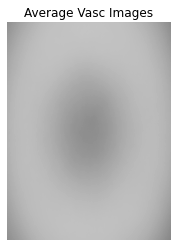

array([[121.11101 , 122.14468 , 122.84349 , ..., 119.93995 , 118.71974 ,
        117.54959 ],
       [122.58053 , 123.72703 , 124.56142 , ..., 121.46952 , 119.99272 ,
        119.01729 ],
       [122.78344 , 124.01911 , 124.747955, ..., 121.76524 , 120.1738  ,
        119.262054],
       ...,
       [121.69427 , 122.42311 , 123.208374, ..., 116.711555, 115.545044,
        114.91993 ],
       [121.50591 , 122.17652 , 123.054596, ..., 116.464966, 115.33849 ,
        114.60964 ],
       [120.98453 , 121.68972 , 122.56961 , ..., 115.86988 , 114.70428 ,
        113.95268 ]], dtype=float32)

In [41]:
EDA.find_mean_img(bkl_images, "Vasc Images")

Contrast Between Images

Principal Component Analysis. 

Number of PC:  6


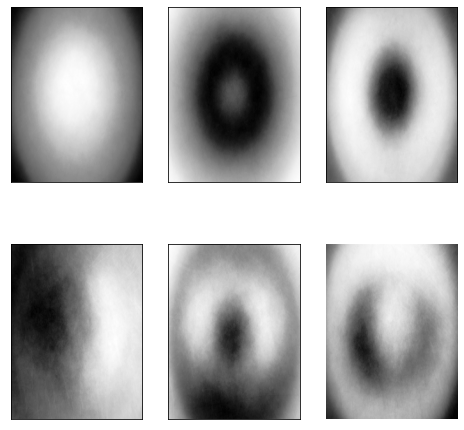

In [42]:
EDA.plot_pca(EDA.eigenimages(bkl_images, "bkl images"))

# 4. Data Processing for Model Ingestion

# 5. Model Creation

# 6. Model Scoring & Evaluation

# 7. Interpretation of Results